
### **Introduction**

In this analysis, we focus on understanding and predicting patient churn in a healthcare clinic. Patient churn, or the likelihood of patients ceasing to engage with the clinic, is a critical factor in healthcare as it directly impacts both patient outcomes and clinic revenue. Our goal is to identify high-risk patients who are most likely to churn, understand the underlying factors contributing to churn, and explore ways to improve patient retention.

This study employs a combination of clustering and predictive modeling to segment patients and analyze their engagement patterns. Specifically, we:

1. **Segment Patients**: Using K-Means clustering, we group patients into distinct clusters based on demographic, behavioral, and appointment-related features.
2. **Analyze Risk Factors**: We investigate how factors like travel time, past no-shows, and appointment frequency contribute to patient churn.
3. **Predict Churn Probability**: A Random Forest model is trained on relevant patient data to predict churn, providing actionable insights for retaining high-risk patients.

By leveraging both clustering and predictive modeling, this analysis enables the clinic to prioritize patient engagement strategies and minimize potential revenue loss due to churn.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load Our Data

In [2]:
patient_df = pd.read_csv("patient_data.csv")
appointment_df = pd.read_csv("appointment_data.csv")

In [3]:
appointment_df = appointment_df.drop(columns=['Distance_From_Clinic','Patient_Charges'])

In [4]:
patient_df.head()

,PatientID,Sex,Age,Diagnosis,Distance_From_Clinic,Income_Range,Insurance_Status,Patient_Active
0,10f82408-6a5f-4f33-8560-1ccacefe79dc,Female,15,Autism,5.538173,Medium,Insured,1
1,1cc55de1-2751-494a-b4c6-e599dd33730e,Male,9,Autism,3.757246,Medium,Insured,1
2,d3ef974a-9998-40b0-9651-8372bf1092db,Female,10,ADHD,1.002337,High,Insured,1
3,419781ff-f647-49c2-beea-85748c83edc3,Male,13,Anxiety,2.032669,Medium,Insured,1
4,efa32c9e-fc3a-4d0a-a3d3-d50518a23e5b,Male,18,Autism,1.284932,Medium,Insured,1


In [5]:
appointment_df.head()

,PatientID,AppointmentID,Appointment_Date,Day_Of_Week,Appointment_Time,No_Show,Reminder_Type,Previous_No_Shows,Travel_Time,Traffic_Delay,Weather,Transportation_Method
0,326385e5-271c-4eff-9787-ef4c3875cd82,8b4a7ac9-dbfe-4f85-9084-c83303f6992a,2023-08-13,Monday,09:30,1,SMS,1,11.360897,10.617526,Cloudy,Car
1,c2a87daa-de20-4201-9115-b479deb3dd93,5ce0cba3-bf35-4bff-b51b-57a69fa83d6a,2023-09-15,Friday,13:00,0,SMS,0,4.217312,0.550820,Sunny,Car
2,9ecd7b33-3baa-45b7-a7c3-65a2a9c2d5e7,e6663746-bba7-4627-a63d-3a8bfb6f1388,2023-12-29,Monday,15:30,0,Email,0,5.992517,27.220919,Rainy,Car
3,58c7fc1a-4328-430b-b125-61e7b4a287aa,4b3e1785-5b15-4b20-bc81-20864e12f7f1,2023-07-31,Thursday,11:00,0,Phone Call,0,2.577590,14.295300,Cloudy,Car
4,1f2ec0a3-bca7-40fa-9b65-6d041cca9147,749527f5-af3c-406d-b6b2-30e89e094ff9,2023-04-20,Thursday,16:00,0,SMS,0,-1.242030,24.427606,Sunny,Car


In [6]:
merged_df = pd.merge(patient_df, appointment_df, on='PatientID', how='inner')

In [7]:
missing_data = merged_df.isnull().sum()
missing_data

PatientID                0
Sex                      0
Age                      0
Diagnosis                0
Distance_From_Clinic     0
Income_Range             0
Insurance_Status         0
Patient_Active           0
AppointmentID            0
Appointment_Date         0
Day_Of_Week              0
Appointment_Time         0
No_Show                  0
Reminder_Type            0
Previous_No_Shows        0
Travel_Time              0
Traffic_Delay            0
Weather                  0
Transportation_Method    0
dtype: int64

In [8]:
merged_df.value_counts('Patient_Active')

Patient_Active
1    8479
0     115
dtype: int64

# View Our Data

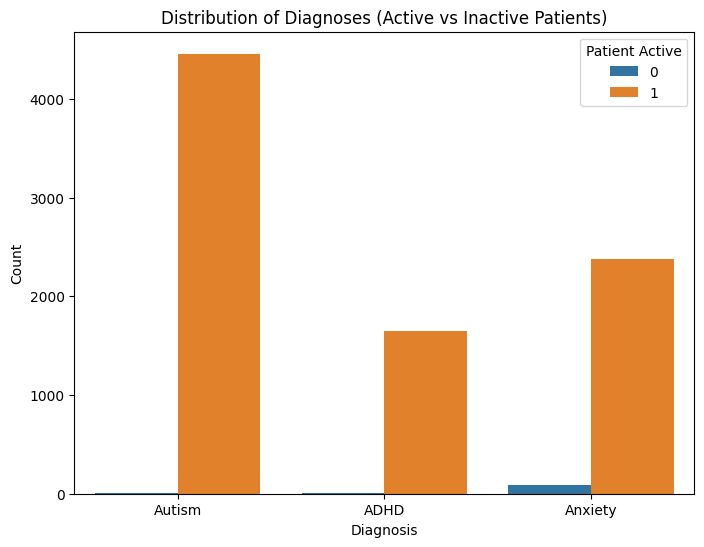

/var/folders/pc/mw8924qn53n51t5y4nmnrh5r0000gn/T/ipykernel_59086/2214265383.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Patient Active')


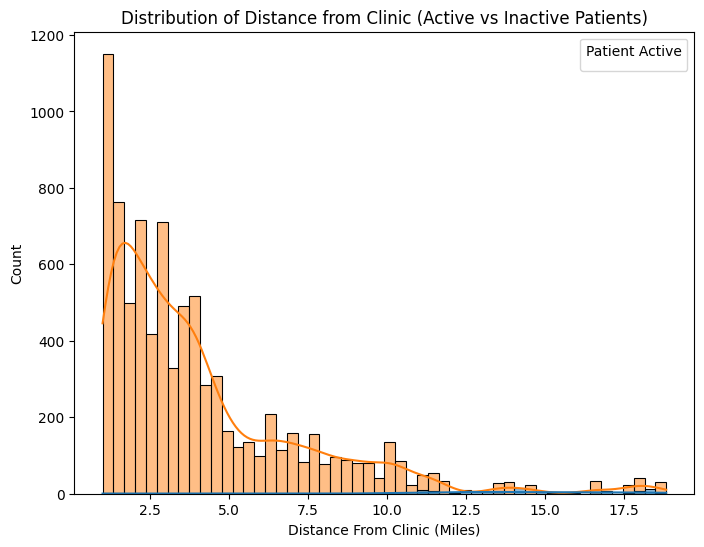

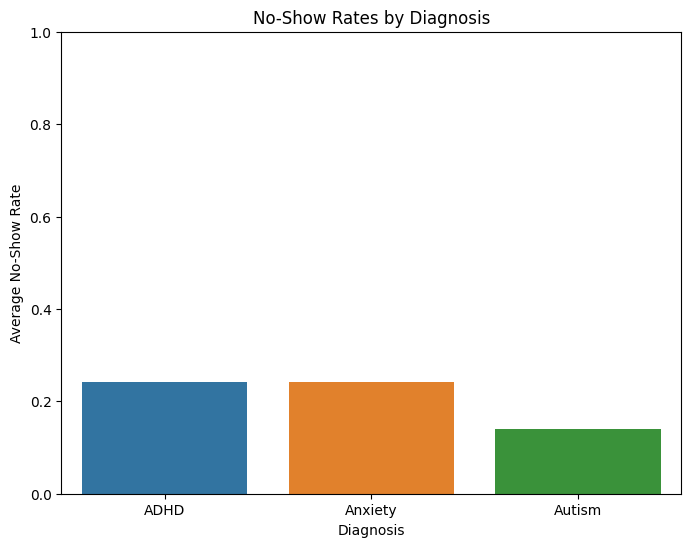

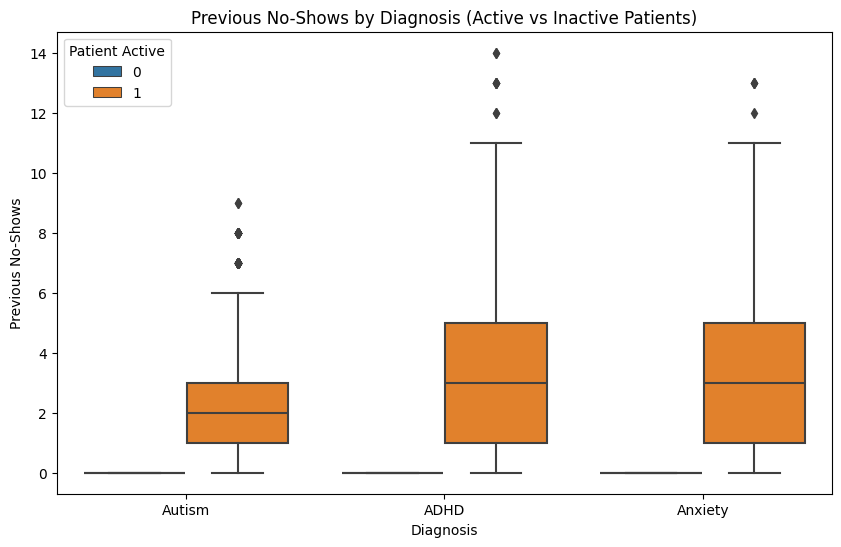

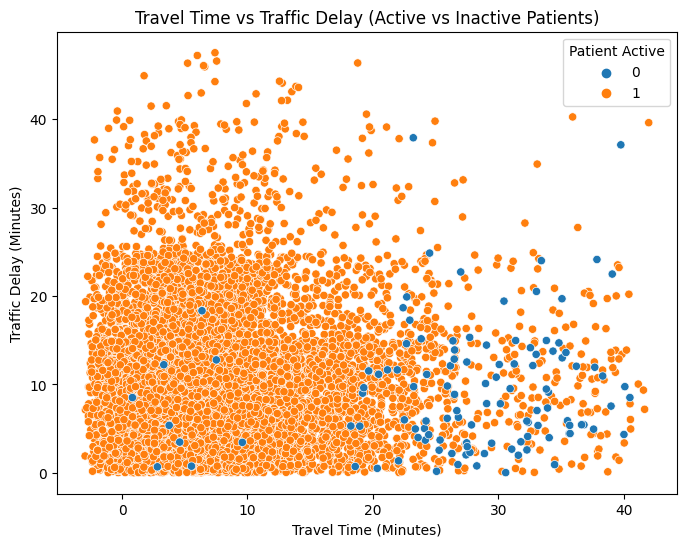

In [9]:

# 1. Distribution of Diagnoses
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x='Diagnosis', hue='Patient_Active')
plt.title('Distribution of Diagnoses (Active vs Inactive Patients)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.legend(title='Patient Active')
plt.show()

# 2. Distance from Clinic
plt.figure(figsize=(8, 6))
sns.histplot(data=merged_df, x='Distance_From_Clinic', hue='Patient_Active', kde=True)
plt.title('Distribution of Distance from Clinic (Active vs Inactive Patients)')
plt.xlabel('Distance From Clinic (Miles)')
plt.ylabel('Count')
plt.legend(title='Patient Active')
plt.show()

# 3. No-Show Rates by Diagnosis
plt.figure(figsize=(8, 6))
no_show_rates_by_diagnosis = merged_df.groupby('Diagnosis')['No_Show'].mean().reset_index()
sns.barplot(data=no_show_rates_by_diagnosis, x='Diagnosis', y='No_Show')
plt.title('No-Show Rates by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Average No-Show Rate')
plt.ylim(0, 1)
plt.show()

# 4. Inactive vs. Active Patients by Diagnosis and Previous No-Shows
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Diagnosis', y='Previous_No_Shows', hue='Patient_Active')
plt.title('Previous No-Shows by Diagnosis (Active vs Inactive Patients)')
plt.xlabel('Diagnosis')
plt.ylabel('Previous No-Shows')
plt.legend(title='Patient Active')
plt.show()

# 5. Travel Time vs Traffic Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='Travel_Time', y='Traffic_Delay', hue='Patient_Active')
plt.title('Travel Time vs Traffic Delay (Active vs Inactive Patients)')
plt.xlabel('Travel Time (Minutes)')
plt.ylabel('Traffic Delay (Minutes)')
plt.legend(title='Patient Active')
plt.show()


# K-Means Cluster Analysis

In [10]:
# select our relevant columns
features = ['Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay', 'Previous_No_Shows', 'Diagnosis', 'Income_Range']

# separate numeric and categorical columns
numeric_columns = ['Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay', 'Previous_No_Shows']
categorical_features = ['Diagnosis', 'Income_Range']

In [11]:
# normalize numeric data
scaler = StandardScaler()
merged_df[numeric_columns] = scaler.fit_transform(merged_df[numeric_columns])

In [12]:
# One-hot encode our categorical data
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categories = encoder.fit_transform(merged_df[categorical_features])

# Combine numeric and encoded categorical data
X = np.hstack([merged_df[numeric_columns].values, encoded_categories])

In [13]:
# find the number of clusters using the elbow method
inertia = []
K = range(1, 11)  # 1 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

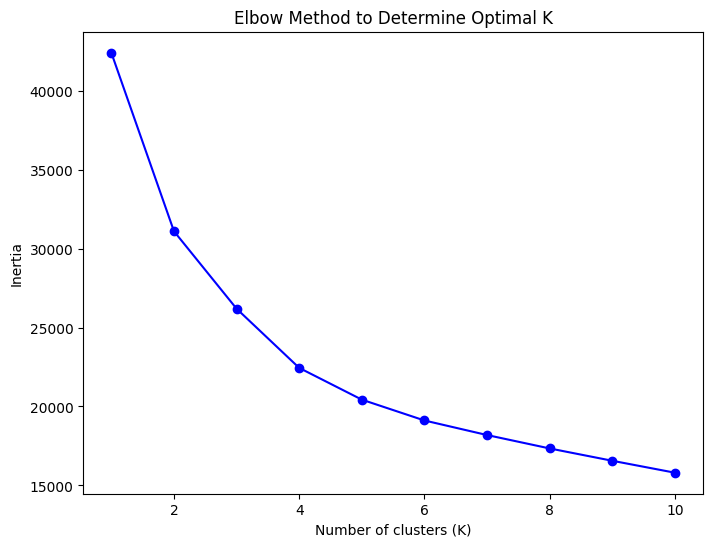

In [14]:
# plot
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal K')
plt.show()

In [15]:
# choose our K and fit the K-means model
optimal_k = 3  # Example, you can adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [16]:
# add cluster labels to the DataFrame 
merged_df['Cluster'] = kmeans.labels_

In [17]:
# Group by 'Cluster' and calculate statistics
cluster_summary = merged_df.groupby('Cluster')[numeric_columns].mean()

print(cluster_summary)

         Distance_From_Clinic  Travel_Time  Traffic_Delay  Previous_No_Shows
Cluster                                                                     
0                   -0.412595    -0.401346       0.045400          -0.512229
1                    1.760009     1.693224      -0.056569          -0.155626
2                   -0.293107    -0.271976      -0.063556           1.271861


The output you've shared shows the mean of the normalized values for each numeric feature within each cluster. Since you applied `StandardScaler` earlier, these values are in a standardized form (i.e., they have a mean of 0 and a standard deviation of 1). The numbers represent how much the clusters deviate from the overall mean (0) of the standardized features.

Here’s how to interpret the results:

### Cluster Interpretation:
- **Cluster 0**: 
  - Has lower than average `Distance_From_Clinic` and `Travel_Time` (negative values), meaning patients in this cluster tend to live closer to the clinic and have shorter travel times compared to the overall population.
  - Slightly positive `Traffic_Delay`, meaning traffic delays are somewhat higher than average.
  - Below average `Previous_No_Shows`, meaning patients in this cluster are less likely to have missed appointments compared to the overall average.

- **Cluster 1**: 
  - Has much higher than average `Distance_From_Clinic` and `Travel_Time`, meaning patients in this cluster tend to live farther from the clinic and have longer travel times.
  - Negative `Traffic_Delay`, meaning delays tend to be lower for this cluster.
  - `Previous_No_Shows` are slightly below average.

- **Cluster 2**: 
  - Has slightly lower than average `Distance_From_Clinic` and `Travel_Time`, meaning patients tend to live closer to the clinic.
  - Negative `Traffic_Delay`, meaning traffic delays are lower than average.
  - Significantly higher `Previous_No_Shows`, meaning patients in this cluster are much more likely to have missed appointments compared to the others.


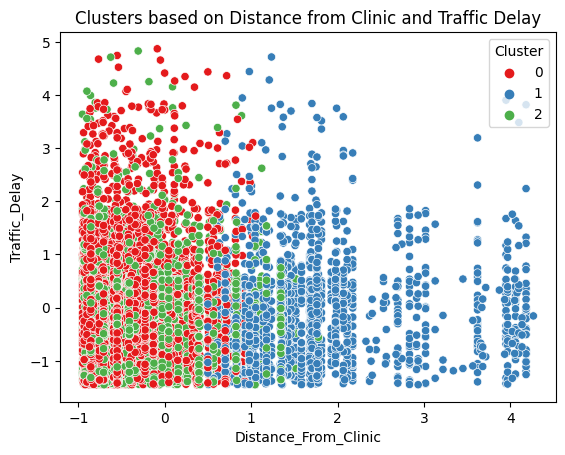

In [18]:
# view clusters based on features 
sns.scatterplot(data=merged_df, x='Distance_From_Clinic', y='Traffic_Delay', hue='Cluster', palette='Set1')
plt.title('Clusters based on Distance from Clinic and Traffic Delay')
plt.show()

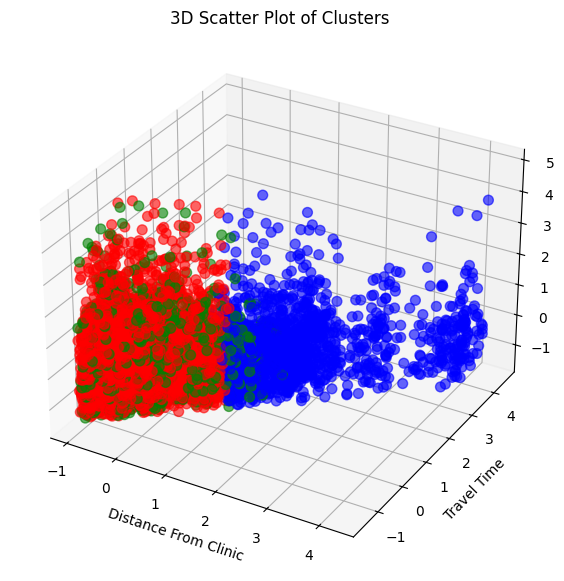

In [19]:
# see if 3d model is easier to view
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assigning colors to clusters
colors = ['red', 'blue', 'green']
cluster_colors = [colors[label] for label in merged_df['Cluster']]

# plot based on our 3 features
sc = ax.scatter(
    merged_df['Distance_From_Clinic'], 
    merged_df['Travel_Time'], 
    merged_df['Traffic_Delay'], 
    c=cluster_colors, 
    s=50,  # marker size
    alpha=0.6  # transparency
)

ax.set_xlabel('Distance From Clinic')
ax.set_ylabel('Travel Time')
ax.set_zlabel('Traffic Delay')

ax.set_title('3D Scatter Plot of Clusters')

plt.show()

# Denormalize the Features

In [20]:
#denormalize the data using inverse_transform on our normalized features
denormalized_features = scaler.inverse_transform(merged_df[['Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay', 'Previous_No_Shows']])

# replace the normalized columns in the DataFrame with the denormalized values
merged_df[['Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay', 'Previous_No_Shows']] = denormalized_features

print(merged_df[['Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay', 'Previous_No_Shows']].head())

   Distance_From_Clinic  Travel_Time  Traffic_Delay  Previous_No_Shows
0              5.538173     8.162513       5.067393                0.0
1              5.538173    14.182556       6.705841                0.0
2              5.538173    11.026130       1.631306                0.0
3              5.538173     7.988428      24.905160                0.0
4              5.538173     6.301103       0.014702                0.0


In [21]:
# Count the frequency of each Diagnosis in each cluster
diagnosis_cluster = merged_df.groupby('Cluster')['Diagnosis'].value_counts().unstack()
print(diagnosis_cluster)

# Count the frequency of each Income Range in each cluster
income_cluster = merged_df.groupby('Cluster')['Income_Range'].value_counts().unstack()
print(35*'-')
print(income_cluster)

Diagnosis  ADHD  Anxiety  Autism
Cluster                         
0           704     1048    3164
1           372      435     706
2           582      983     600
-----------------------------------
Income_Range  High   Low  Medium
Cluster                         
0              954  2121    1841
1              427   359     727
2              391   878     896


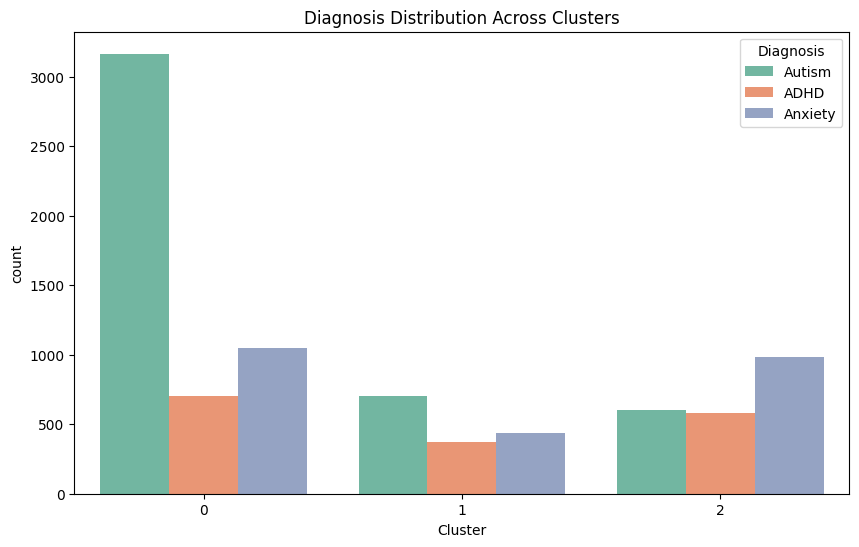

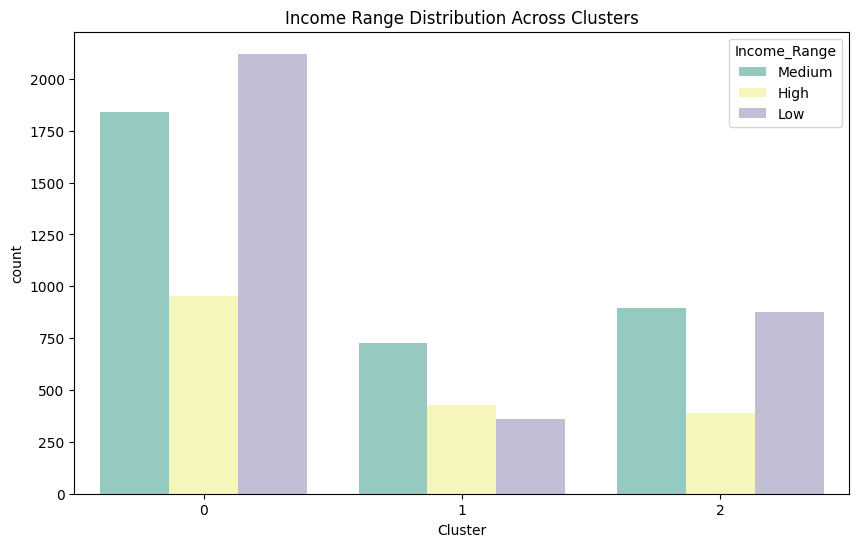

In [22]:
# View our cluster distributions

# Diagnosis distribution across our 3 clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Cluster', hue='Diagnosis', palette='Set2')
plt.title('Diagnosis Distribution Across Clusters')
plt.show()

# Income Range distribution across clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Cluster', hue='Income_Range', palette='Set3')
plt.title('Income Range Distribution Across Clusters')
plt.show()

# Targeted Analysis

In [23]:
# average Previous_No_Shows by Diagnosis and Cluster
no_show_diagnosis = merged_df.groupby(['Cluster', 'Diagnosis'])['Previous_No_Shows'].mean().unstack()
print("Average No-Shows by Diagnosis and Cluster:")
print(no_show_diagnosis)

# average Previous_No_Shows by Income Range and Cluster
no_show_income = merged_df.groupby(['Cluster', 'Income_Range'])['Previous_No_Shows'].mean().unstack()
print("\nAverage No-Shows by Income Range and Cluster:")
print(no_show_income)

Average No-Shows by Diagnosis and Cluster:
Diagnosis      ADHD   Anxiety    Autism
Cluster                                
0          1.427557  1.391221  1.391593
1          2.491935  2.411494  1.916431
2          5.994845  5.398779  4.886667

Average No-Shows by Income Range and Cluster:
Income_Range      High       Low    Medium
Cluster                                   
0             1.393082  1.377181  1.420967
1             2.440281  1.880223  2.217331
2             5.370844  5.454442  5.400670


### Targeted Analysis Insights:

#### 1. **Average No-Shows by Diagnosis and Cluster**:

- **Cluster 0**:
  - All diagnoses (ADHD, Anxiety, Autism) show relatively similar average no-show rates (~1.39), which is on the lower end compared to the other clusters.
  - This suggests that the no-show problem is more controlled in Cluster 0, likely due to some effective intervention or structural factors (like patients being closer to the clinic).

- **Cluster 1**:
  - No-shows are higher for **ADHD** (2.49) and **Anxiety** (2.41), while **Autism** has a lower rate (1.91).
  - This indicates that ADHD and Anxiety patients are more likely to miss appointments in this cluster.

- **Cluster 2**:
  - **All diagnoses** have a significantly higher no-show rate, with ADHD patients having the highest (5.99), followed by Anxiety (5.39) and Autism (4.89).
  - This cluster is clearly the most challenging when it comes to managing no-shows, particularly for ADHD patients.

#### 2. **Average No-Shows by Income Range and Cluster**:

- **Cluster 0**:
  - The no-show rates are quite similar across income ranges, with **Medium** income patients having the slightly higher rate (1.42). Overall, this cluster is well-managed in terms of no-shows.
  
- **Cluster 1**:
  - **High income** patients have the highest no-show rate (2.44), followed by **Medium** (2.21) and **Low** income (1.88).
  - This suggests that high-income patients may need different engagement strategies in this cluster.

- **Cluster 2**:
  - Across the board, no-show rates are high for all income ranges (around 5.4), but slightly lower for **High income** patients (5.37).
  - This suggests that income doesn’t play as much of a differentiating factor in Cluster 2, as no-show rates are generally elevated.

---

### Strategic Insights and Recommendations:

Based on these results, we can develop cluster-specific strategies to reduce no-shows:

#### **Cluster 0** (Overall low no-show rates):
- **Diagnosis Insights**:
  - All diagnoses have similar no-show rates, indicating that this cluster is already well-managed. 
  - **Recommendation**: Continue using existing engagement strategies (e.g., phone calls, SMS reminders), and consider minor optimizations (like better scheduling or reduced wait times).
  
- **Income Insights**:
  - There is no significant difference in no-shows by income range.
  - **Recommendation**: Maintain current practices as this group seems to be stable.

#### **Cluster 1** (Higher no-show rates for ADHD and high-income patients):
- **Diagnosis Insights**:
  - ADHD and Anxiety patients are the most likely to miss appointments.
  - **Recommendation**: Introduce **targeted phone call reminders** for ADHD and Anxiety patients. Explore **telehealth options** or **remote consultations** for patients with ADHD who may struggle with in-person appointments.

- **Income Insights**:
  - **High-income** patients have the highest no-show rate.
  - **Recommendation**: Consider testing **SMS reminders** or **digital notifications** for high-income patients, as they may prefer more tech-savvy approaches. Alternatively, explore flexible scheduling options or patient portals that provide more self-service tools for booking and reminders.

#### **Cluster 2** (Severe no-show problem):
- **Diagnosis Insights**:
  - ADHD patients have an extremely high no-show rate, followed by Anxiety and Autism patients.
  - **Recommendation**: Focus efforts on **ADHD patients** with personalized interventions (e.g., **behavioral incentives**, **frequent reminders**, **financial assistance**, or more flexible scheduling). For all patients in this cluster, consider offering **penalties for frequent no-shows** balanced with financial incentives for attending multiple consecutive appointments.

- **Income Insights**:
  - All income groups show similarly high no-show rates.
  - **Recommendation**: Offer **transportation assistance** for **low-income patients**, and test out **financial incentives** or **discounts** for regular attendance. For high-income patients, you might experiment with more **personalized concierge services** (e.g., direct outreach, priority scheduling) to make attendance easier.


# Churn Prediction

In [24]:
# logistic regression model

# patients with 3 or more no-shows are labeled as churned for our target
merged_df['Churn'] = (merged_df['Previous_No_Shows'] >= 3).astype(int)

X = merged_df[['Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay', 'Diagnosis', 'Income_Range']]
y = merged_df['Churn']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.606048856145793
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      1523
           1       0.52      0.57      0.54      1056

    accuracy                           0.61      2579
   macro avg       0.60      0.60      0.60      2579
weighted avg       0.61      0.61      0.61      2579



In [25]:
# Random Forest Classifier

numeric_features = ['Age', 'Distance_From_Clinic', 'Travel_Time', 'Traffic_Delay']
categorical_features = ['Sex', 'Diagnosis', 'Income_Range', 'Insurance_Status', 'Reminder_Type', 'Weather', 'Transportation_Method', 'Day_Of_Week', 'Cluster']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

X = merged_df[numeric_features + categorical_features]  
y = merged_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8410236525785189
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      1523
           1       0.91      0.68      0.78      1056

    accuracy                           0.84      2579
   macro avg       0.86      0.82      0.83      2579
weighted avg       0.85      0.84      0.84      2579



# feature importances

In [26]:
# feature importances from the RandomForest model
rf_model = pipeline.named_steps['classifier']
importances = rf_model.feature_importances_

encoded_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_features = numeric_features + list(encoded_features)

# Combine feature names with their importance
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance.head(10))

                     Feature  Importance
22                 Cluster_2    0.351921
2                Travel_Time    0.120921
3              Traffic_Delay    0.112638
1       Distance_From_Clinic    0.101005
0                        Age    0.070476
6           Diagnosis_Autism    0.028669
4                   Sex_Male    0.017280
14             Weather_Sunny    0.016227
11         Reminder_Type_SMS    0.015795
10  Reminder_Type_Phone Call    0.014775


# Hyperparameter Tuning

In [27]:
# GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees
    'classifier__max_depth': [10, 20, 30, None],  # Max depth of trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4]     # Minimum samples at a leaf node
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

y_pred_best = grid_search.best_estimator_.predict(X_test)

print(f"\nBest Model Accuracy: {accuracy_score(y_test, y_pred_best)}")
print(classification_report(y_test, y_pred_best))

Best Hyperparameters: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}

Best Model Accuracy: 0.8452888716556805
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1523
           1       0.91      0.69      0.78      1056

    accuracy                           0.85      2579
   macro avg       0.86      0.82      0.83      2579
weighted avg       0.86      0.85      0.84      2579



Here’s a summary of the insights gained from both the **K-means analysis** and the **churn prediction analysis**:

---

### **K-Means Clustering Analysis:**

- **Key Findings**:
  - **Cluster 0**: Dominated by patients with **Autism** and a higher proportion of **Low-income** patients. This group had relatively low no-show rates (~1.39), suggesting they may already be well-managed with existing engagement strategies.
  - **Cluster 1**: More balanced in terms of diagnosis distribution (between **Anxiety** and **Autism**) but with **High-income** patients showing higher no-show rates. This cluster had moderate no-show rates (~2.2 to 2.4), indicating potential for improvement.
  - **Cluster 2**: Patients with **ADHD** and **Anxiety** diagnoses experienced the highest no-show rates (~5.9 for ADHD and ~5.4 for Anxiety). This group also had a mix of low- and medium-income patients, suggesting more targeted interventions could reduce their no-shows.

- **Strategic Insights**:
  - **Cluster 0**: Maintain current strategies as no-show rates are already low, but consider minor optimizations.
  - **Cluster 1**: Experiment with different reminder strategies (e.g., SMS reminders) for high-income patients and flexible scheduling for anxiety patients.
  - **Cluster 2**: Implement behavioral incentives, offer telehealth options, and consider transportation assistance to reduce no-shows, particularly for ADHD and low-income patients.

---

### **Churn Prediction Analysis:**

- **Model Performance**:
  - **Final Model**: RandomForestClassifier with hyperparameter tuning, achieving:
    - **Accuracy**: 84.5%
    - **Precision for Churners**: 0.91 (91% of predicted churners were correct).
    - **Recall for Churners**: 0.69 (69% of actual churners were correctly identified).
  - **Key Features**: Factors like **Previous_No_Shows**, **Travel_Time**, and **Reminder_Type** played an important role in predicting churn. High recall for non-churners (95%) suggests that the model is conservative in predicting churn, favoring precision.

- **Strategic Insights**:
  - High-risk churn patients can be identified early based on their previous no-show behavior and other factors like long travel times or ineffective reminders.
  - Offering more flexible scheduling, transportation support, or telehealth options may help reduce churn for high-risk patients, particularly those with ADHD or Anxiety diagnoses.
  - Patients receiving certain reminder types (e.g., email) may be more likely to churn, suggesting a need for more personalized reminder strategies like phone calls or SMS.

---

### Conclusion:
Both the **K-means clustering** and **churn prediction** analyses have provided actionable insights into patient behavior. By understanding key drivers of no-shows and churn, targeted interventions such as personalized reminders, financial incentives, and telehealth options can be implemented to improve patient retention and reduce churn rates.


# Visualizations

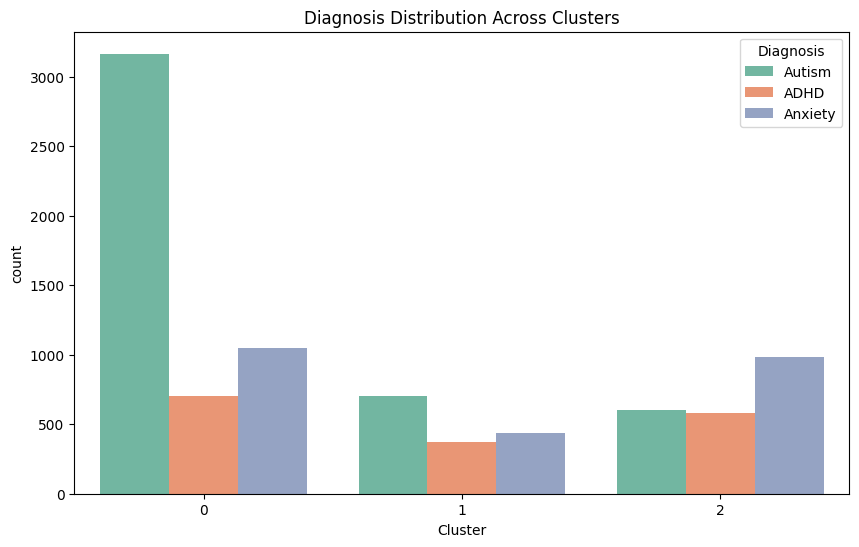

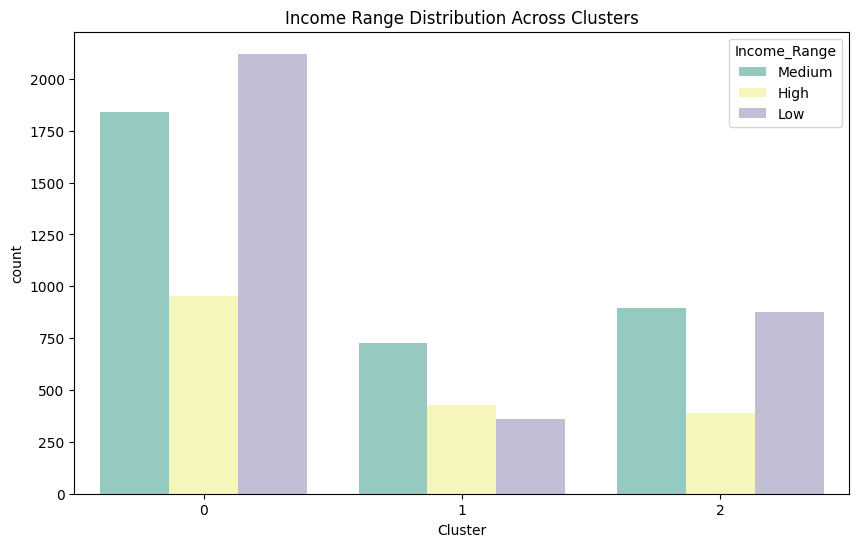

In [28]:
# Diagnosis distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Cluster', hue='Diagnosis', palette='Set2')
plt.title('Diagnosis Distribution Across Clusters')
plt.show()

# Income range distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, x='Cluster', hue='Income_Range', palette='Set3')
plt.title('Income Range Distribution Across Clusters')
plt.show()


<Figure size 1000x600 with 0 Axes>

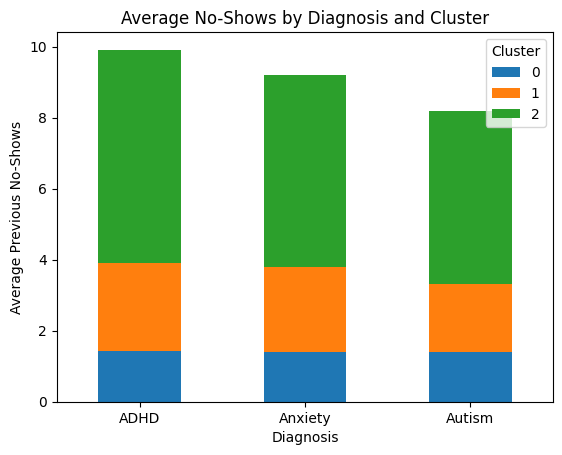

In [29]:
# average No-Shows by Diagnosis and Cluster
plt.figure(figsize=(10, 6))
no_show_diagnosis.T.plot(kind='bar', stacked=True)
plt.title('Average No-Shows by Diagnosis and Cluster')
plt.ylabel('Average Previous No-Shows')
plt.xlabel('Diagnosis')
plt.xticks(rotation=0)
plt.show()

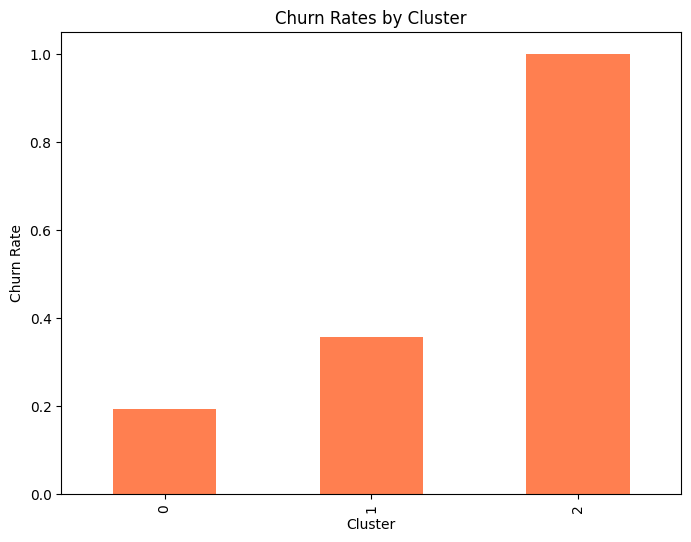

In [30]:
# Calculate churn rates by cluster
churn_by_cluster = merged_df.groupby('Cluster')['Churn'].mean()

plt.figure(figsize=(8, 6))
churn_by_cluster.plot(kind='bar', color='coral')
plt.title('Churn Rates by Cluster')
plt.ylabel('Churn Rate')
plt.xlabel('Cluster')
plt.show()

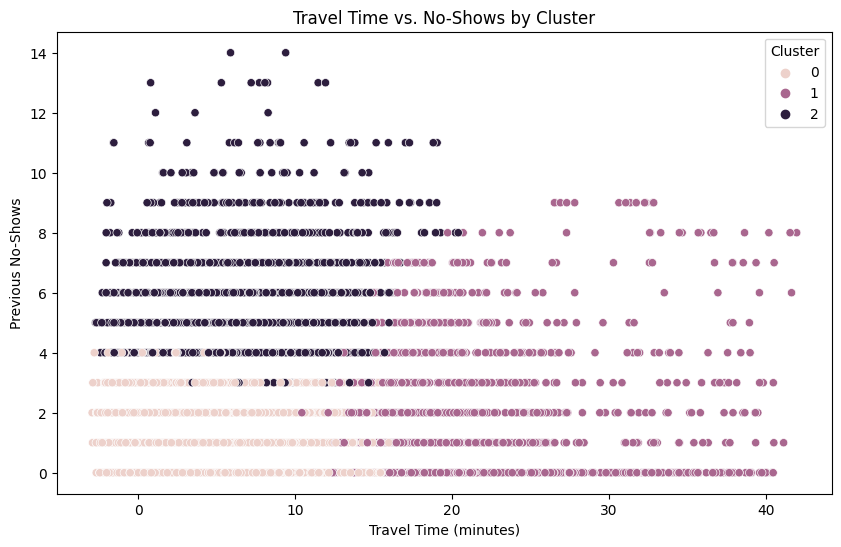

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Travel_Time', y='Previous_No_Shows', hue='Cluster', data=merged_df)
plt.title('Travel Time vs. No-Shows by Cluster')
plt.xlabel('Travel Time (minutes)')
plt.ylabel('Previous No-Shows')
plt.show()

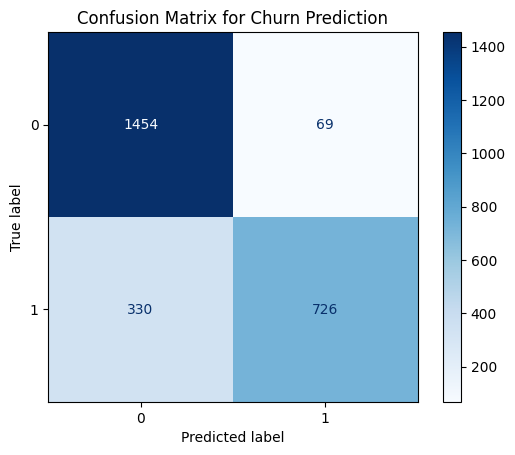

In [32]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Churn Prediction')
plt.show()

# Patient Lifetime Value (PLV) Estimation

In [33]:
# average number of historical appointments per patient
average_historical_appointments = merged_df.groupby('PatientID')['AppointmentID'].nunique().mean()
print(f"Average historical appointments per patient: {average_historical_appointments:.2f}")
print(60*'-')

# estimated future appointments based on historical average
def estimate_future_appointments(row):
    # Base future appointments on historical average
    base_appointments = average_historical_appointments
    
    # Adjust based on previous no-shows 
    no_show_adjustment = max(0, base_appointments - row['Previous_No_Shows'] * 0.5)
    
    # Adjust based on distance from the clinic
    distance_adjustment = no_show_adjustment - (row['Distance_From_Clinic'] * 0.1)
    
    # Ensure a minimum of 1 expected future appointment to avoid zero estimates
    return max(1, distance_adjustment)

# Apply function to estimate future appointments for each patient
merged_df['Estimated_Future_Appointments'] = merged_df.apply(estimate_future_appointments, axis=1)

# Calculate expected lifetime value based on estimated future appointments
average_revenue_per_patient = 225  
merged_df['Expected_Lifetime_Value'] = (1 - merged_df['Churn']) * average_revenue_per_patient * merged_df['Estimated_Future_Appointments']

# Calculate expected no-show cost based on estimated no-show rate per patient
cost_of_no_show = 50  
def estimate_no_show_cost(row):
    # No-show rate adjusted based on previous no-shows and distance factors
    estimated_no_show_rate = min(0.3, row['Previous_No_Shows'] / (row['Estimated_Future_Appointments'] + 1))
    return row['Estimated_Future_Appointments'] * cost_of_no_show * estimated_no_show_rate

merged_df['Expected_No_Show_Cost'] = merged_df.apply(estimate_no_show_cost, axis=1)

# Total financial impact
total_expected_lifetime_value = merged_df['Expected_Lifetime_Value'].sum()
total_expected_no_show_cost = merged_df['Expected_No_Show_Cost'].sum()

print(f"Total Expected Lifetime Value: ${total_expected_lifetime_value:,.2f}")
print(60*'-')
print(f"Total Expected No-Show Cost: ${total_expected_no_show_cost:,.2f}")
print(60*'-')
average_lifetime_value_per_patient = total_expected_lifetime_value / merged_df['PatientID'].nunique()
print(f"Average Expected Lifetime Value per Patient: ${average_lifetime_value_per_patient:,.2f}")

Average historical appointments per patient: 23.16
------------------------------------------------------------
Total Expected Lifetime Value: $24,732,681.51
------------------------------------------------------------
Total Expected No-Show Cost: $986,687.58
------------------------------------------------------------
Average Expected Lifetime Value per Patient: $66,664.91


# Longitudinal Analysis of Patients:
We can track individual patients over time to see how their engagement patterns evolve. This includes changes in no-show behavior, appointment frequency, and identifying trends that show patients gradually disengaging or improving.

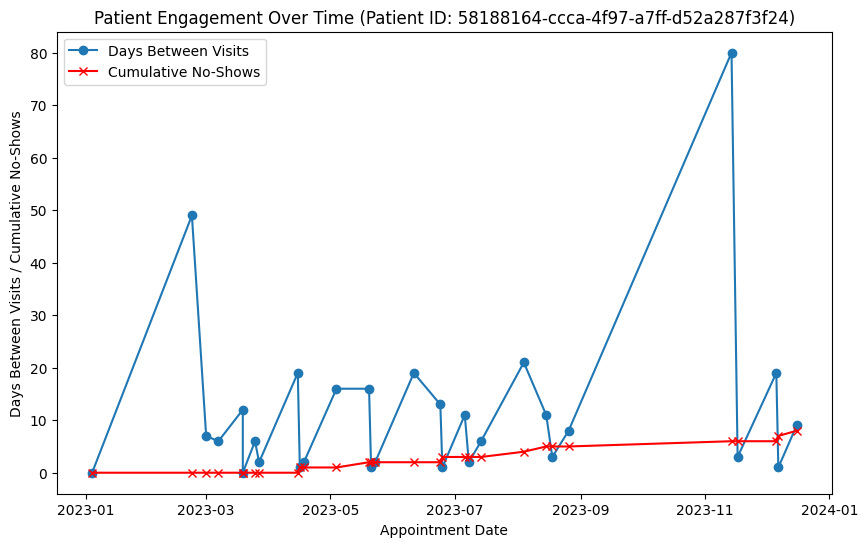

In [35]:
appointment_df['Appointment_Date'] = pd.to_datetime(appointment_df['Appointment_Date'], errors='coerce')

# Sort df by patient and appointment date
appointment_df['Appointment_Date'] = pd.to_datetime(appointment_df['Appointment_Date'])
appointment_df = appointment_df.sort_values(by=['PatientID', 'Appointment_Date'])

# time between appointments 
appointment_df['Days_Between_Visits'] = appointment_df.groupby('PatientID')['Appointment_Date'].diff().dt.days

# cumulative no-shows over time 
appointment_df['Cumulative_No_Shows'] = appointment_df.groupby('PatientID')['No_Show'].cumsum()

# no missing values by filling missing 'Days_Between_Visits' with 0
appointment_df['Days_Between_Visits'].fillna(0, inplace=True)

# random patient ID to visualize
sample_patient_id = appointment_df['PatientID'].sample(1).values[0]
sample_patient = appointment_df[appointment_df['PatientID'] == sample_patient_id]

# if the patient has enough data points for plotting
if not sample_patient.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(sample_patient['Appointment_Date'], sample_patient['Days_Between_Visits'], marker='o', label='Days Between Visits')
    plt.plot(sample_patient['Appointment_Date'], sample_patient['Cumulative_No_Shows'], marker='x', color='red', label='Cumulative No-Shows')
    plt.title(f'Patient Engagement Over Time (Patient ID: {sample_patient_id})')
    plt.xlabel('Appointment Date')
    plt.ylabel('Days Between Visits / Cumulative No-Shows')
    plt.legend()
    plt.show()
else:
    print(f"No data available for patient: {sample_patient_id}")

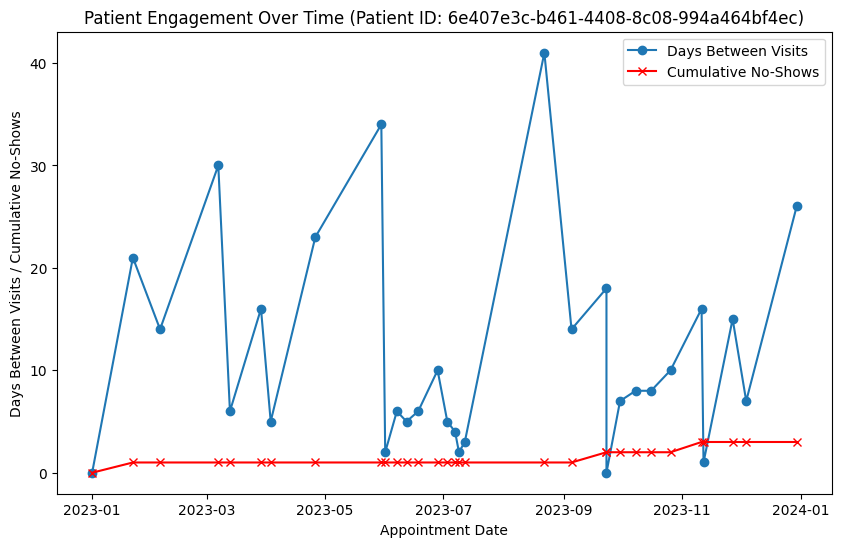

In [36]:
# Compare to another random patient

# another random patient ID to visualize
sample_patient_id = appointment_df['PatientID'].sample(1).values[0]
sample_patient = appointment_df[appointment_df['PatientID'] == sample_patient_id]

if not sample_patient.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(sample_patient['Appointment_Date'], sample_patient['Days_Between_Visits'], marker='o', label='Days Between Visits')
    plt.plot(sample_patient['Appointment_Date'], sample_patient['Cumulative_No_Shows'], marker='x', color='red', label='Cumulative No-Shows')
    plt.title(f'Patient Engagement Over Time (Patient ID: {sample_patient_id})')
    plt.xlabel('Appointment Date')
    plt.ylabel('Days Between Visits / Cumulative No-Shows')
    plt.legend()
    plt.show()
else:
    print(f"No data available for patient: {sample_patient_id}")

# Top 10 Patients at Risk of Churn

In [37]:
active_high_risk_patients = merged_df[merged_df['Churn'] == 0]

# Sort patients based on high-risk indicators
active_high_risk_patients = active_high_risk_patients.sort_values(
    by=['Previous_No_Shows', 'Distance_From_Clinic', 'Travel_Time'], 
    ascending=[False, False, False]
)

top_10_active_high_risk_patients = active_high_risk_patients[['PatientID', 'Previous_No_Shows', 'Distance_From_Clinic', 'Travel_Time']].drop_duplicates('PatientID').head(10)

top_10_active_high_risk_patients

,PatientID,Previous_No_Shows,Distance_From_Clinic,Travel_Time
5712,040cb562-a85e-4251-9187-b2df5bb9b2a5,2.0,18.554586,33.781317
8122,1115d369-24cf-44b5-b561-913a675729bc,2.0,18.138640,35.281237
5247,7fe0d13c-df80-4c64-a4f7-c538592888c7,2.0,17.827416,39.351951
934,185626e4-5b62-40b4-9fce-538b79200974,2.0,17.760960,39.507264
1190,e7d41884-d09e-4610-9e12-67a49531996f,2.0,16.636700,37.924285
5138,f61ed478-9118-4fae-ba1d-85259c4c4d64,2.0,14.580439,29.427017
6719,f048fe76-ea00-4fc7-bd5e-431eac34d082,2.0,13.944253,31.397953
4413,101d3c48-4199-43c5-b06e-5f425a1f8e00,2.0,13.481872,30.587573
443,d6e36401-ffcb-4357-9164-20936f877645,2.0,11.695963,26.630310
1513,acf4b118-8198-4cba-a5e1-901ec0cc5918,2.0,11.473714,27.340280



### **Conclusion**

Our analysis has led to a comprehensive understanding of the key factors influencing patient churn and has highlighted a subset of active patients who are at high risk of churning. Notably:

- **Key Churn Indicators**: We found that **previous no-show rates**, **distance from the clinic**, and **travel time** are the most significant predictors of churn, with patients who have a history of missed appointments and live farther away exhibiting the highest churn probabilities.
- **Targeted Retention Opportunities**: The K-Means clustering revealed distinct patient segments, allowing the clinic to implement targeted interventions. For example, patients with high no-show rates may benefit from personalized appointment reminders, such as phone calls instead of emails or SMS.
- **Financial Impact**: Through our Expected Lifetime Value and No-Show Cost calculations, we estimated both the revenue potential and costs associated with no-shows for each patient, highlighting the importance of reducing churn to protect clinic profitability.

Overall, this analysis equips the clinic with data-driven insights to improve patient engagement, reduce churn, and enhance long-term patient loyalty. By focusing on high-risk patients, the clinic can implement proactive measures that not only improve patient outcomes but also sustain financial health.
